# Base VGG training and testing

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

## Constants (parameters) initialization

In [ ]:
device_id = 0
num_workers = 4

batch_size = 128
default_learning_rate = 0.1

In [ ]:
!pip install joypy

## CIFAR-10 data load and preproc

In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import PIL.Image as Image
from torch import nn
import numpy as np
import torch.optim as optim
import pandas as pd
import torch
from torchvision import transforms, utils
import torchvision.models as models
import torchvision.datasets as datasets
import os
import sys
import random
from tqdm import tqdm as tqdm
from IPython import display
import joypy as joy
import pickle
from scipy.stats import t
import math

In [ ]:
# add our package dir to path 
module_path = os.path.dirname(os.getcwd())
sys.path.append(module_path)

home_path = module_path
figures_path = os.path.join(home_path, 'reports', 'figures')
models_path = os.path.join(home_path, 'reports', 'models')

Make sure you are using the right device.

In [ ]:
device_id = device_id
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]=str(device_id)

device = torch.device("cuda:{}".format(device_id) if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device_id))

cuda:0
Tesla T4


In [ ]:
class PartialDataset(Dataset):
    def __init__(self, dataset, n_items=10):
        self.dataset = dataset
        self.n_items = n_items
        
    def __getitem__(self):
        return self.dataset.__getitem__()
    
    def __len__(self):
        return min(self.n_items, len(self.dataset))

In [ ]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
train_transform = transforms.Compose(
    [#transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    normalize
    ])
val_transform = transforms.Compose(
    [transforms.ToTensor(),
    normalize
    ])

dataset_train = datasets.CIFAR10(root='../data/', train=True, download=True, transform=train_transform)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)

dataset_val = datasets.CIFAR10(root='../data/', train=False, download=True, transform=val_transform)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=num_workers)


n_items = 10
dataset_train_part = PartialDataset(dataset_train, n_items)
train_loader_part = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ../data/cifar-10-python.tar.gz to ../data/
Files already downloaded and verified


Make sure that dataloader works as expected by observing one sample from it.

tensor([[[ 0.4745,  0.2392,  0.1922,  ...,  0.2627,  0.2706,  0.4039],
         [ 0.2471,  0.6314,  0.7569,  ...,  0.8039,  0.7412,  0.4039],
         [ 0.3176,  0.8353,  1.0000,  ...,  1.0000,  0.9765,  0.5529],
         ...,
         [ 0.3647,  0.7804,  1.0000,  ...,  0.9922,  0.9451,  0.5373],
         [ 0.3647,  0.6941,  0.9451,  ...,  0.9294,  0.8745,  0.5137],
         [ 0.4588,  0.4118,  0.5686,  ...,  0.5686,  0.5294,  0.4431]],

        [[-0.0902, -0.1686, -0.0745,  ..., -0.1059, -0.0902, -0.0667],
         [-0.1373,  0.6000,  0.8431,  ...,  0.7804,  0.7412,  0.1686],
         [-0.0353,  0.8353,  1.0000,  ...,  1.0000,  0.9922,  0.3176],
         ...,
         [-0.0510,  0.8118,  1.0000,  ...,  0.9922,  0.9294,  0.3020],
         [-0.0275,  0.7569,  0.9765,  ...,  0.9373,  0.8667,  0.2863],
         [-0.0275,  0.2471,  0.3961,  ...,  0.3961,  0.3412,  0.0980]],

        [[-0.6627, -0.4745, -0.4353,  ..., -0.4431, -0.4039, -0.5451],
         [-0.5765,  0.6235,  0.8431,  ...,  0

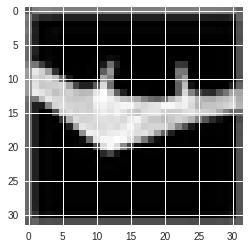

In [ ]:
for X,y in train_loader:
    print(X[0])
    print(y[0])
    print(X[0].shape)
    plt.imshow(np.array(X[0,0,:,:]))
    print(X[0].max())
    print(X[0].min())
    break

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/DeepLearningSeminar

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1KvCYqyyyX8lqacflKvCCyhGm_MBMJA06/DeepLearningSeminar


## Models implementation

In [ ]:
save = True

In [ ]:
def get_number_of_parameters(model):
    parameters_n = 0
    for parameter in model.parameters():
        parameters_n += np.prod(parameter.shape).item()
        
    return parameters_n

In [ ]:
class VGG_A(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10,train_num=0):
        super().__init__()
        
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage6 = nn.Sequential(
            nn.Linear(512*1*1, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes))
        
        self.epoch = 0
        self.write = True
        self.train_num= train_num
    
    def save_activations(self, activation, layer):
      if save:
        if self.write:
          torch.save(activation[:,:,:,-1],
                     'val_his/No_batch/No_batch_train{}_epoch{}_layer{}.pt'.
                     format(self.train_num,self.epoch,layer))
          if layer == 8:
            self.epoch += 1
            self.write =False
                 


    def forward(self, x):
      if not self.training:
        self.write = True
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x.view(-1, 512*1*1))
      else:
        x = self.stage1(x)
        self.save_activations(x,1)
        x = self.stage2(x)
        x = self.stage3(x)
        self.save_activations(x,4)
        x = self.stage4(x)
        x = self.stage5(x)
        self.save_activations(x,8)
        x = self.stage6(x.view(-1, 512*1*1))
        self.write = False
      return x

In [ ]:
class VGG_A_Batch(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10, train_num=0):
        super().__init__()
        
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage6 = nn.Sequential(
            nn.Linear(512*1*1, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, num_classes))
        
        self.epoch = 0
        self.write = True
        self.train_num = train_num


    def save_activations(self, activation, layer):
      if save:
        if self.write:
          torch.save(activation[:,:,:,-1],'val_his/Batch/Batch_trian{}_epoch{}_layer{}.pt'.format(self.train_num,self.epoch,layer))
          if layer == 8:
            self.epoch += 1
            self.write =False
          

    def forward(self, x):
        if not self.training:
          self.write = True
          x = self.stage1(x)
          x = self.stage2(x)
          x = self.stage3(x)
          x = self.stage4(x)
          x = self.stage5(x)
          x = self.stage6(x.view(-1, 512*1*1))
        else:
          x = self.stage1(x)
          self.save_activations(x,1)
          x = self.stage2(x)
          x = self.stage3(x)
          self.save_activations(x,4)
          x = self.stage4(x)
          x = self.stage5(x)
          self.save_activations(x,8)
          x = self.stage6(x.view(-1, 512*1*1))
          self.write = False
        return x

In [ ]:
class VGG_A_Batch_noise(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10,train_num=0):
        super().__init__()
        
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage6 = nn.Sequential(
            nn.Linear(512*1*1, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, num_classes))
        
        self.epoch = 0
        self.write = True
        self.train_num = train_num

    def get_some_noise(self, activations, n_mean=0.1,n_var=0.3,r_mean=0.05,r_var=0.05):
        shape = activations.size()
        
        means = torch.rand(shape[-1]) * (2*n_mean) + n_mean
        vars =  torch.rand(shape[-1]) * (1 - n_var) + n_var

        bias = torch.rand(shape) * (2*r_mean) + means + r_mean
        var = torch.normal(mean=torch.zeros(shape),std=r_var) + vars
        return activations * var.to(device='cuda') + bias.to(device='cuda')

    def save_activations(self, activation, layer):
      if save:
        if self.write:
          torch.save(activation[:,:,:,-1],
                    'val_his/Batch_noise/Batch_noise_train{}_epoch{}_layer{}.pt'.
                     format(self.train_num,self.epoch,layer))
          
          if layer == 8:
            self.epoch += 1
            self.write =False
          


    def forward(self, x):
        if not self.training:
          self.write = True
          x = self.stage1(x)
          x = self.get_some_noise(x)
          x = self.stage2(x)
          x = self.get_some_noise(x)
          x = self.stage3(x)
          x = self.get_some_noise(x)
          x = self.stage4(x)
          x = self.get_some_noise(x)
          x = self.stage5(x)
          x = self.get_some_noise(x)
          x = self.stage6(x.view(-1, 512*1*1))
        else:
          x = self.stage1(x)
          x = self.get_some_noise(x)
          self.save_activations(x,1)
          x = self.stage2(x)
          x = self.get_some_noise(x)
          x = self.stage3(x)
          x = self.get_some_noise(x)
          self.save_activations(x,4)
          x = self.stage4(x)
          x = self.get_some_noise(x)
          x = self.stage5(x)
          x = self.get_some_noise(x)
          self.save_activations(x,8)
          x = self.stage6(x.view(-1, 512*1*1))
          self.write = False
        return x

## Final preparations for training

In [ ]:
def get_accuracy(model, dataloader, device='cpu'):
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)  ## <---
            y = y.to(device)  ## <---Size
            prediction = model(x).argmax(dim=-1, keepdim=True)
            correct += prediction.eq(y.view_as(prediction)).sum().item()
    return correct / len(dataloader.dataset)

In [ ]:
def set_random_seeds(seed_value=0, device='cpu'):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
def train(model, 
          optimizer, 
          criterion,  
          train_loader, 
          val_loader, 
          scheduler=None, 
          epochs_n=100, 
          best_model_path=None):
    
    model.to(device)
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    batches_n = len(train_loader)
    grads = []
    for epoch in tqdm(range(epochs_n), unit='epoch'):
        if scheduler is not None:  
            scheduler.step()       
        model.train()
        grad = []
        learning_curve[epoch] = 0
        for data in train_loader:
            
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)

            learning_curve[epoch] += loss.item()
            loss.backward()
            grad.append(model.stage6[4].weight.grad.clone())
            optimizer.step()
        grads.append(grad)
        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        learning_curve[epoch] /= batches_n
        axes[0].plot(learning_curve)

        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader, device)
        
        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            if best_model_path:
                torch.save(model.state_dict(), best_model_path)
        
        axes[1].set_title('Train {:.4f}, val {:.4f}, max val {:.4f} at {}'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve)
        axes[1].plot(val_accuracy_curve)

        plt.tight_layout()
        plt.show()
    return grads, val_accuracy_curve, train_accuracy_curve

## Training

In [ ]:
def train_with_noise(epo,lr,train_num, seed_val):
  set_random_seeds(seed_value=seed_val, device=device)

  model = VGG_A_Batch_noise(train_num=train_num)

  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  criterion = nn.CrossEntropyLoss()


  return train(model, 
        optimizer, 
        criterion, 
        train_loader,
        val_loader,
        epochs_n=epo)


In [ ]:
def train_batch(epo,lr,train_num, seed_val):
  set_random_seeds(seed_value=seed_val, device=device)

  model = VGG_A_Batch(train_num=train_num)

  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  criterion = nn.CrossEntropyLoss()


  return train(model, 
        optimizer, 
        criterion, 
        train_loader,
        val_loader,
        epochs_n=epo)


In [ ]:
def train_no_batch(epo,lr,train_num, seed_val):
  set_random_seeds(seed_value=seed_val, device=device)

  model = VGG_A(train_num=train_num)

  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  criterion = nn.CrossEntropyLoss()


  return train(model, optimizer, criterion, train_loader, val_loader, epochs_n=epo)

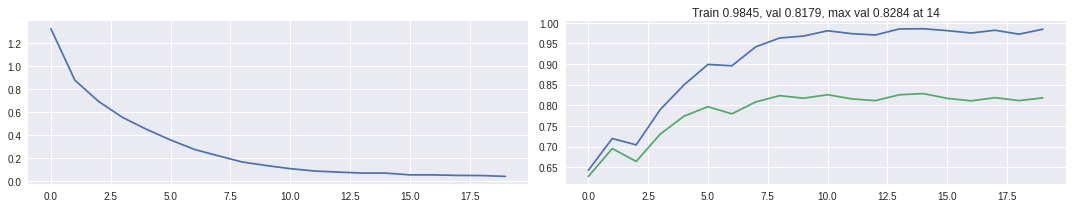

100%|██████████| 20/20 [09:40<00:00, 29.00s/epoch]


In [ ]:
save = True
trains_num = 10
epo = 20
lr = 0.0015

train_acc_with_noise = []
train_acc_batch = []
train_acc_no_batch = []
val_acc_with_noise = []
val_acc_batch = []
val_acc_no_batch = []
seed_val = 2000
for i in range( trains_num):
  grad,val,train = train_no_batch(epo,lr,i, seed_val + i)
  train_acc_no_batch.append(train)
  val_acc_no_batch.append(val)
  pickle.dump(train, open("train_acc_no_batch" + str(i) + ".p", "wb"))
  pickle.dump(val, open("val_acc_no_batch" + str(i) + ".p", "wb"))


  grad,val,train = train_with_noise(epo,lr,i, seed_val + i)
  train_acc_with_noise.append(train)
  val_acc_with_noise.append(val)
  pickle.dump(train, open("train_acc_with_noise_file" + str(i) + ".p", "wb"))
  pickle.dump(val, open("val_acc_with_noise" + str(i) + ".p", "wb"))
  
  
  grad,val,train = train_batch(epo,lr,i, seed_val + i)
  train_acc_batch.append(train)
  val_acc_batch.append(val)
  pickle.dump(train, open("train_acc_batch" + str(i) + ".p", "wb"))
  pickle.dump(val, open("val_acc_batch" + str(i) + ".p", "wb"))





##Visualizing

In [ ]:
#use in order to rename files

# files = os.listdir()
# for file in files:
#   if "test" in file:
#     new_name = file.replace("test","train")
#     os.rename(file,new_name)
#   if "_noise_" in file:
#     new = ''
#     result = new.join(file.rsplit("_", 1))
#     os.rename(file,result)

train_acc_with_noise0.p
train_acc_with_noise5.p
train_acc_with_noise6.p
train_acc_with_noise1.p
train_acc_with_noise2.p
train_acc_with_noise3.p
train_acc_with_noise8.p
train_acc_with_noise4.p
train_acc_with_noise7.p
train_acc_with_noise9.p


In [ ]:
import pickle

val_acc_batch = []
val_acc_no_batch = []
val_acc_with_noise = []
train_acc_batch = []
train_acc_no_batch = []
train_acc_with_noise = []

files_dict = {
         "val_acc_batch":val_acc_batch,
         "val_acc_no_batch":val_acc_no_batch,
         "val_acc_with_noise":val_acc_with_noise,
         "train_acc_batch":train_acc_batch,
         "train_acc_no_batch":train_acc_no_batch,
         "train_acc_with_noise":train_acc_with_noise
         }
        

for file_name,arr in files_dict.items():
  for i in range(9):
    arr.append(pickle.load( open(
        "{}{}.p".format(file_name,i), "rb" ) ))

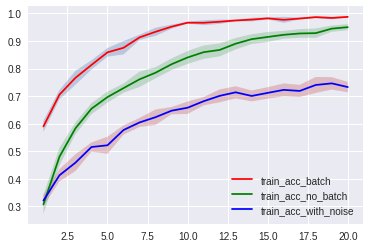

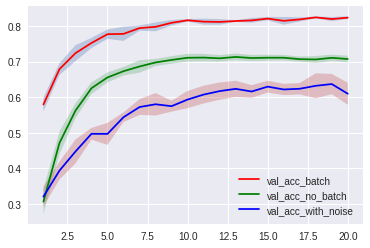

In [ ]:
ppf = t(df=9).ppf(0.975)

colors = ["red","green","blue"]
train_fig, train_ax = plt.subplots()
val_fig, val_ax = plt.subplots()
count_val = 0
count_train = 0
for name,arr in files_dict.items():
  df = pd.DataFrame(arr)
  df.index.name = "iteration"
  
  means = np.array(df.mean())
  y_confidenc = np.array(df.std())/math.sqrt(10)*ppf
  upper = means+y_confidenc
  lower = means-y_confidenc
  if "val" in name:
    val_ax.plot(np.arange(1,21), means, label=name,color=colors[count_val])
    val_ax.fill_between(np.arange(1,21),lower,upper,alpha=0.3)
    count_val+=1
  else:
    train_ax.plot(np.arange(1,21), means, label=name,color=colors[count_train])
    train_ax.fill_between(np.arange(1,21),lower,upper,alpha=0.3)
    count_train+=1
  
  # sns.lineplot(data=flights, x="year", y="passengers")
  
val_ax.legend()
train_ax.legend()
plt.show()

In [ ]:
%matplotlib inline

def plot_hist(df,layer,model_type = "Batch norm with noise"):
  labels=[e for e in list(df.epoch.unique())]
  fig, axes = joy.joyplot(df, by="epoch", column="data", labels=labels, range_style='own', 
                            grid="y", linewidth=1, legend=False, figsize=(6,5),
                            title="Model {} layer {}".format(model_type,layer),colormap=plt.cm.viridis)

In [ ]:
directory = {"No_batch":"val_his/No_batch/",
             "Batch_noise":"val_his/Batch_noise/",
             "Batch":"val_his/Batch/"}

layer_dict = {1:0,4:1,8:2}

files = []
for val in directory.values():             
  files += os.listdir(val)



no_batch_frames = []
batch_frames = []
noise_batch_frames = []
stages = {1:0,4:1,8:2}
for stage in stages:
  noise_batch_frames.append(pd.DataFrame({"epoch":[],"data":[]}))
  batch_frames.append(pd.DataFrame({"epoch":[],"data":[]}))
  no_batch_frames.append(pd.DataFrame({"epoch":[],"data":[]}))

  
for file in tqdm(files):
  if file.endswith(".pt") and ('train0' in file or "trian0" in file):
    file_data = file.split("_epoch")
    epoch,layer = int(file_data[-1].split("_layer")[0]),int(file_data[-1].split("_layer")[1][:-3])
    if "train" in file:
      file_data = file_data[0].split("_train")
    elif "trian" in file:
      file_data = file_data[0].split("_trian")

    model_type, train_num = file_data[0],file_data[1]
    dir = directory[model_type]
    data = torch.load(dir+file).detach().cpu().numpy()
    data = data.reshape((-1))
    epoch_array = np.ones_like(data) * epoch
  
    if model_type == "Batch_noise":
      temp_df = pd.DataFrame({"epoch":epoch_array,"data":data})
      if len(noise_batch_frames[layer_dict[layer]]):
        noise_batch_frames[layer_dict[layer]] = noise_batch_frames[layer_dict[layer]].append(temp_df)
      else:
        noise_batch_frames[layer_dict[layer]] = temp_df


    elif model_type == "Batch":
      temp_df = pd.DataFrame({"epoch":epoch_array,"data":data})
      if len(batch_frames[layer_dict[layer]]):
        batch_frames[layer_dict[layer]] = batch_frames[layer_dict[layer]].append(temp_df)
      else:
        batch_frames[layer_dict[layer]] = temp_df


    elif model_type == "No_batch":
      temp_df = pd.DataFrame({"epoch":epoch_array,"data":data})
      if len(no_batch_frames[layer_dict[layer]]):
        no_batch_frames[layer_dict[layer]] = no_batch_frames[layer_dict[layer]].append(temp_df)
      else:
        no_batch_frames[layer_dict[layer]] = temp_df




100%|██████████| 1800/1800 [00:02<00:00, 705.14it/s]



0it [00:00, ?it/s]
1it [01:04, 64.65s/it]
2it [02:10, 64.92s/it]
3it [02:45, 55.13s/it]


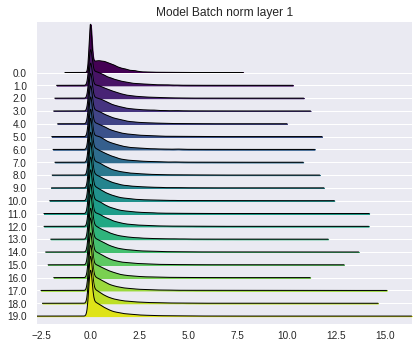

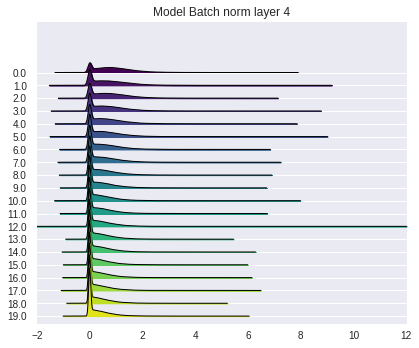

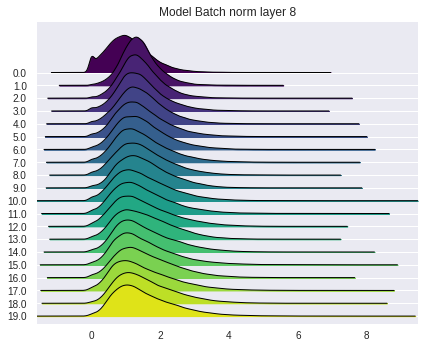

In [ ]:
layer_dict = {0:1,1:4,2:8}
for idx, df in tqdm(enumerate(batch_frames)):
  plot_hist(df, layer_dict[idx],"Batch norm")


0it [00:00, ?it/s]
1it [01:04, 64.78s/it]
2it [02:07, 64.15s/it]
3it [02:39, 53.28s/it]


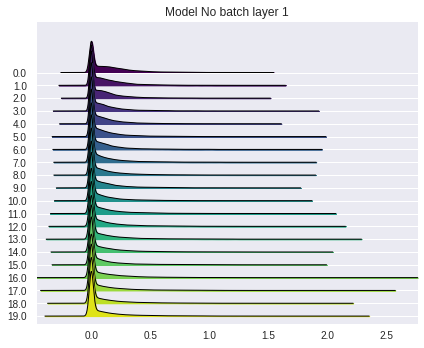

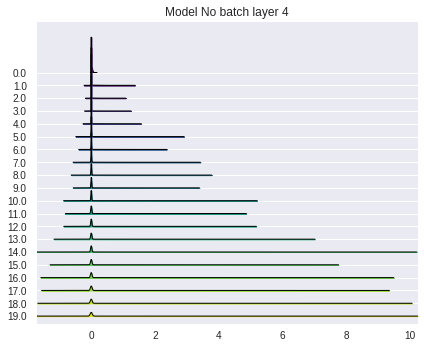

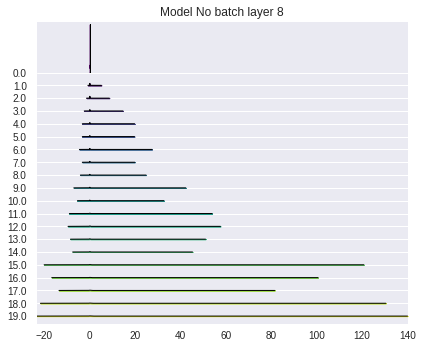

In [ ]:
layer_dict = {0:1,1:4,2:8}
for idx, df in tqdm(enumerate(no_batch_frames)):
  plot_hist(df, layer_dict[idx],model_type='No batch')


0it [00:00, ?it/s]
1it [01:05, 65.66s/it]
2it [02:12, 65.98s/it]
3it [02:47, 55.87s/it]


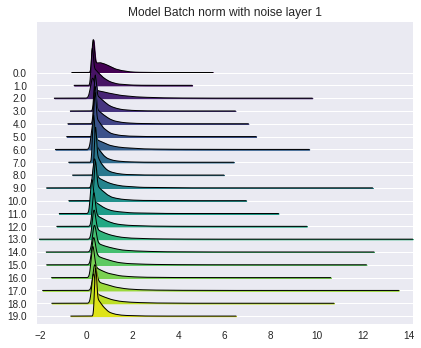

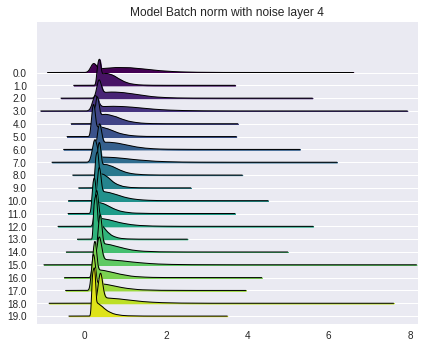

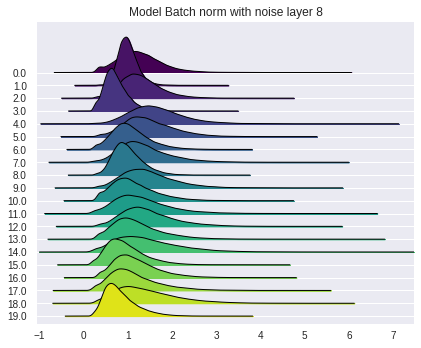

In [ ]:
layer_dict = {0:1,1:4,2:8}
for idx, df in tqdm(enumerate(noise_batch_frames)):
  plot_hist(df, layer_dict[idx])